# Exercise 1: Non-Parametric Estimation

## Exercise 1, Part 1

In [7]:
# Import libraries
from sklearn.datasets import fetch_openml
import numpy as np

# Load the dataset
data = fetch_openml('mnist_784')

C:\Users\Calvin Tran\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


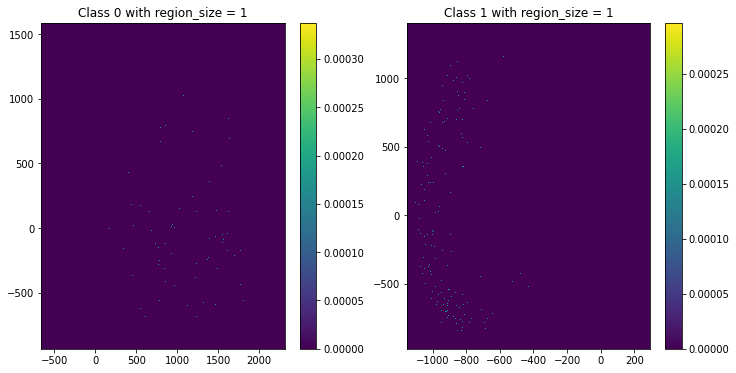

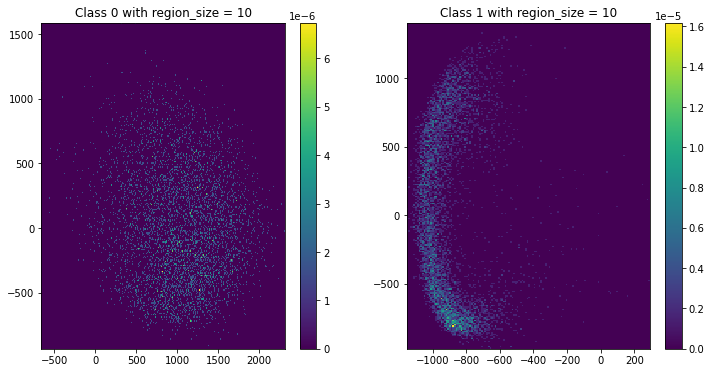

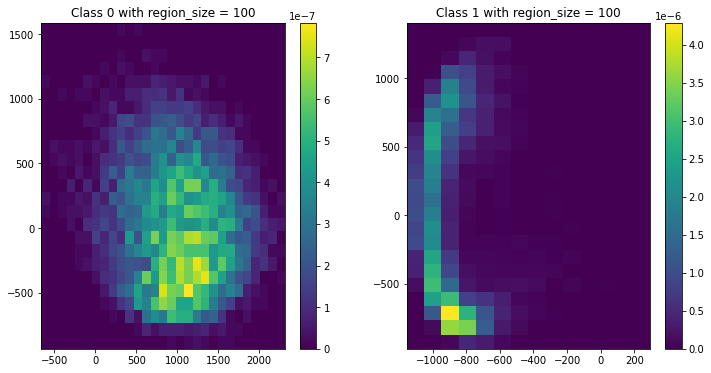

In [85]:
import sklearn.model_selection
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Split data
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    data['data'], data['target'], test_size=0.142857142, shuffle=False,
)

# Only use first two classes of training data
Y_train = Y_train.astype(int)
filter = np.isin(Y_train, [0, 1])
X = X_train[filter]
Y = Y_train[filter]

# Convert 784x1 vectors into 2x1 vectors
pca = PCA(n_components=2)
X_PCA = pca.fit_transform(X)

region_sizes = [1, 10, 100]

for size in region_sizes:
    fig, axes =  plt.subplots(ncols=2, figsize=(12, 6))

    for num, ax in enumerate(axes):
        # Retrieve data for that class
        num_data = X_PCA[Y == num]
        # Calculate bins
        x_1_bin = int((num_data[:, 0].max() - num_data[:, 0].min()) / size)
        x_2_bin = int((num_data[:, 1].max() - num_data[:, 1].min()) / size)

        # Graph
        graph = ax.hist2d(num_data[:, 0], num_data[:, 1], bins=(x_1_bin, x_2_bin), density=True)
        ax.set_title(f"Class {num} with region_size = {size}")
        plt.colorbar(graph[3], ax=ax)
    plt.show()


## Exercise 1, Part 2

In [123]:
# Filter test dataset and transform
Y_test = Y_test.astype(int)
filter = np.isin(Y_test, [0, 1])
X_test = X_test[filter]
Y_test = Y_test[filter]
X_test_PCA = pca.fit_transform(X_test)

def calc_llh(hist, x1_range, x2_range, x):
    # Determine bin index for each coordinate
    x1_bin_num = np.digitize(x[0], x1_range) - 1
    x1_bin_num = min(max(x1_bin_num, 0), hist.shape[0] - 1)

    x2_bin_num = np.digitize(x[1], x2_range) - 1
    x2_bin_num = min(max(x2_bin_num, 0), hist.shape[1] - 1)

    # Retrieve the likelihood value from the histogram using the computed indices
    likelihood = hist[x1_bin_num, x2_bin_num]

    return likelihood

def classifier(X_test_data, region_size):
    preds = []
    prob_dists = []
    x1_ranges = []
    x2_ranges = []

    # Create probability distribution histograms
    for num in [0,1]:
        # Retrieve data
        num_data = X_PCA[Y == num]

        # Calculate bins
        x1_bins = int((num_data[:, 0].max() - num_data[:, 0].min()) / region_size)
        x2_bins = int((num_data[:, 1].max() - num_data[:, 1].min()) / region_size)
        
        # Create probability distribution histograms
        dist, x1_range, x2_range = np.histogram2d(num_data[:, 0], num_data[:, 1], bins=(x1_bins, x2_bins), density=True)
        prob_dists.append(dist)
        x1_ranges.append(x1_range)
        x2_ranges.append(x2_range)

    # Calculate likelihoods for each point in test data
    for point in X_test_data:
        preds.append(np.argmax([calc_llh(dist, x1_range, x2_range, point) for dist, x1_range, x2_range in zip(prob_dists, x1_ranges, x2_ranges)]))

    return np.array(preds)
    
for size in region_sizes:
    # Calculate error rate for each region size
    err_rate = np.mean(classifier(X_test_PCA, size) != Y_test)
    print(f"The percent error for a region size of {size} is {err_rate*100:.2f}%.")

The percent error for a region size of 1 is 53.24%.
The percent error for a region size of 10 is 25.25%.
The percent error for a region size of 100 is 0.38%.


## Exercise 1, Part 3

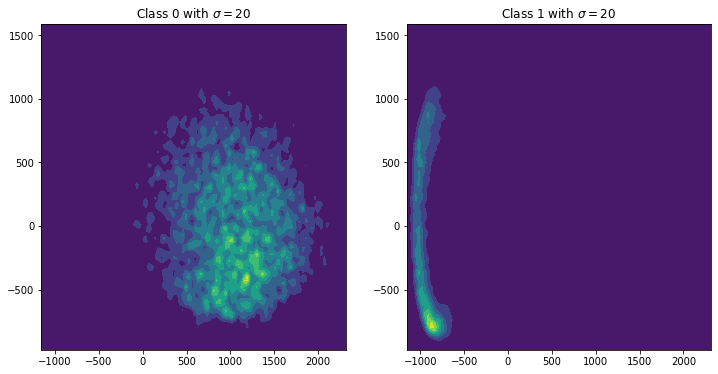

The percent error for the kernel-based density estimation is 0.28%.


In [126]:
from sklearn.neighbors import KernelDensity

# Plot the kernel-based density estimation
kernel_0 = KernelDensity(kernel='gaussian', bandwidth=20).fit(X_PCA[Y == 0])
kernel_1 = KernelDensity(kernel='gaussian', bandwidth=20).fit(X_PCA[Y == 1])

# Create a meshgrid for X and Y coordinates
xx, yy = np.meshgrid(np.linspace(X_PCA[:, 0].min() - 1, X_PCA[:, 0].max() + 1, 100), np.linspace(X_PCA[:, 1].min() - 1, X_PCA[:, 1].max() + 1, 100))
stack = np.vstack([xx.ravel(), yy.ravel()]).T

fig, axes =  plt.subplots(ncols=2, figsize=(12, 6))

# Calculate probabilities for class 0 and graph
llh_0 = kernel_0.score_samples(stack)
dist_0 = (np.exp(llh_0)).reshape(xx.shape)
axes[0].contourf(xx, yy, dist_0)
axes[0].set_title("Class 0 with $\sigma=20$")

# Calculate probabilities for class 1 and graph
llh_1 = kernel_1.score_samples(stack)
dist_1 = (np.exp(llh_1)).reshape(xx.shape)
axes[1].contourf(xx, yy, dist_1)
axes[1].set_title("Class 1 with $\sigma=20$")

plt.show()

# Create classifier
def kernel_classifier(X_test_data):
    kernel_0 = KernelDensity(kernel='gaussian', bandwidth=20).fit(X_PCA[Y == 0])
    kernel_1 = KernelDensity(kernel='gaussian', bandwidth=20).fit(X_PCA[Y == 1])

    res = []
    prob_0 = np.exp(kernel_0.score_samples(X_test_data))
    prob_1 = np.exp(kernel_1.score_samples(X_test_data))
    for i in range(len(X_test_data)):
        point_res = 0 if prob_0[i] > prob_1[i] else 1
        res.append(point_res)
    
    return np.array(res)

err_rate = np.mean(kernel_classifier(X_test_PCA) != Y_test)
print(f"The percent error for the kernel-based density estimation is {err_rate*100:.2f}%.")


# Exercise 2

## Part 1

In [140]:
import numpy as np

def k_means(data, k, max_iterations=100):
    # Randomly initialize cluster centres
    centres = data[np.random.choice(data.shape[0], k, replace=False)]
    
    for i in range(max_iterations):

        # Calculate euclidean distances
        distances = np.array([np.linalg.norm(data - centre, axis=1) for centre in centres])

        # Assign each data point to the nearest cluster centre based on euclidean distance
        labels = np.argmin(distances, axis=0)
        
        # Update centres of each class based on the mean of assigned data points
        new_centres = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        
        # Check for convergence
        if np.all(centres == new_centres):
            break
        
        # Update new centres
        centres = new_centres
    
    return centres

Ks = [5, 10, 20, 40]

for k in Ks:
    centres = kmeans(X_train, k)





KeyError: "None of [Int64Index([3048, 19563, 58303, 8870, 40228], dtype='int64')] are in the [columns]"